In [101]:
import numpy as np
import pandas as pd

x = np.random.normal(size=(100,2))
y = 2*x+np.random.normal(scale=1e-1, size=(100,2))

data = pd.DataFrame(np.hstack((x,y)), columns=['x1', 'x2', 'y1', 'y2'])

print(data.shape)

(100, 4)


In [102]:
import numpy as np
import pandas as pd
import lingam

# To run causal discovery, we create a DirectLiNGAM object and call the fit method.
model = lingam.DirectLiNGAM()
model.fit(data)

# Using the causal_order_ properties, 
# we can see the causal ordering as a result of the causal discovery.
print(model.causal_order_)

# Also, using the adjacency_matrix_ properties, 
# we can see the adjacency matrix as a result of the causal discovery.
print(model.adjacency_matrix_)

[2, 0, 1, 3]
[[0.         0.         0.49225023 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         2.00515348 0.         0.        ]]


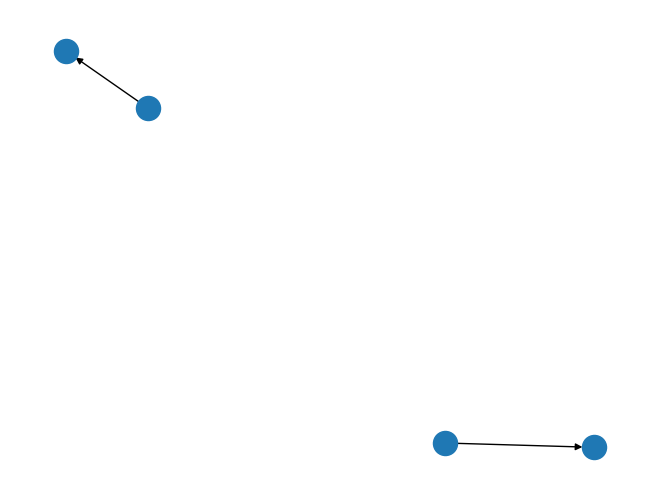

In [103]:
import networkx as nx

causal_graph = nx.DiGraph(model.adjacency_matrix_)

nx.draw(causal_graph)

In [113]:
from typing import Union, Callable, Iterable, Optional, Any, Tuple, List
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import KernelDensity


class Kernel:

    """
    Implements a product kernel given a list of kernel functions
    """
    
    def __init__(self, kernel_functions: Iterable[Callable], kernel_coefficients: Optional[Iterable[float]] = None) -> None:
        self.kernel_functions = kernel_functions
        if kernel_coefficients is None:
            kernel_coefficients = np.ones_like(kernel_functions)
        self.kernel_coefficients = kernel_coefficients

    def __call__(self, x, feature: int, causal_graph: 'nx.Digraph') -> Any:
        preceding_features = causal_graph.predecessors(feature)
        prod = 1
        x = np.array(x)
        for feat in preceding_features:
            coeff = self.kernel_coefficients[feat]
            partial_res = self.kernel_functions[feat](x[feat]/coeff)/coeff 
            prod*=partial_res
            if partial_res > 1:
                raise ValueError(f'Error: rbf kernel gave {self.kernel_functions[feat](x[feat])} with {x[feat]}')
            if partial_res==0:
                raise ValueError(f'Error: rbf kernel gave {self.kernel_functions[feat](x[feat])} with {x[feat]}')
        return prod

def map_indeces_to_sample(indeces: Iterable, feature_list: Iterable, data: Iterable) -> 'np.Array':
    try:
        data = np.array(data)
    except:
        TypeError(f'Could not cast data of type {type(data)} to numpy array')
    try:
        feature_list = np.array(feature_list)
    except:
        TypeError(f'Could not cast feature_list of type {type(feature_list)} to numpy array')
    try:
        indeces = np.array(list(indeces))
    except:
        TypeError(f'Could not cast indeces of type {type(indeces)} to numpy array')
    if len(indeces.shape)==1:
        indeces = np.reshape(indeces, (1,)+indeces.shape)
    return np.array([[data[sample_index, feature_list[i]] for i, sample_index in enumerate(indeces_of_one_sample)]for indeces_of_one_sample in indeces]) 

def check_sample_is_original(indeces: Iterable):
    return len(np.unique(indeces)) == 1

def causal_augmentation(data: Union['pd.DataFrame', 'np.Array'], causal_graph: nx.Graph, kernel: Kernel, threshold: float, aug_coeff: float) -> Tuple['np.array', 'np.array']:

    weight_dict = dict()
    weight_dict[tuple()] = 1
    feature_list = list(nx.topological_sort(causal_graph))

    for feature_index, feature in tqdm(enumerate(feature_list)):
        new_dict = dict()
        for leaf in weight_dict.keys():
            for current_datum_index in range(len(data)):
                new_leaf = leaf + (current_datum_index,)
                augmented_sample = np.array([data.iloc[sample_index, feature_list[i]] for i, sample_index in enumerate(new_leaf)])
                kernel_results = []
                for k in range(len(data)):
                    truncated_data = data.iloc[k,feature_list[:feature_index+1]]
                    try:
                        kernel_results.append(kernel(augmented_sample-truncated_data, feature, causal_graph))
                    except:
                        raise ValueError(f'Shapes {augmented_sample.shape}, {truncated_data.shape} not compatible\
                                         \nSamples are {augmented_sample}, {truncated_data}')

                den = sum(kernel_results)
                num = kernel(augmented_sample-data.iloc[current_datum_index,feature_list[:feature_index+1]], feature, causal_graph)
                if den>0:
                    w = num/den
                else:
                    w = 0
                w = weight_dict[leaf]*w
                if w>threshold/len(data):
                    new_dict[new_leaf] = w
        weight_dict = new_dict
    
    augmented_data_set = map_indeces_to_sample(weight_dict.keys(), feature_list, data)
    augmented_data_set = np.vstack((np.array(data), augmented_data_set))

    weights_aug = aug_coeff*len(data)*np.array(list(weight_dict.values()))
    weights_orig = (1-aug_coeff)*np.ones((len(data),))
    weights = np.hstack((weights_orig, weights_aug))

    return augmented_data_set, weights

def get_default_kernel_functions_from_df(df: 'pd.DataFrame') -> List[Callable]:
    types = df.dtypes
    kfs = []
    for t in types:
        if pd.api.types.is_integer_dtype(t):
            kfs.append(lambda x: 1 if x==0 else 0)
        elif pd.api.types.is_float_dtype(t):
            kfs.append(lambda x: np.power(2*np.pi, -0.5)*np.exp(-np.power(x, 2)/2))
        else:
            raise TypeError(f'{t} not supported')
    return kfs

In [114]:
import lingam
import numpy as np
import pandas as pd
import networkx as nx

x = np.random.normal(size=(10,1))
y = 2*x+np.random.normal(scale=1e-1, size=x.shape)

data = pd.DataFrame(np.hstack((x,y)))
# To run causal discovery, we create a DirectLiNGAM object and call the fit method.
model = lingam.DirectLiNGAM()
model.fit(data)

causal_graph = nx.DiGraph(model.adjacency_matrix_)

kfs = get_default_kernel_functions_from_df(data)
kernel = Kernel(kfs)
data_aug, weights = causal_augmentation(data, causal_graph, kernel, 0, 0.5)

0it [00:00, ?it/s]

2it [00:02,  1.05s/it]

4.999999999999999
[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.06614828 0.01515651
 0.06429284 0.05815518 0.06602175 0.06275319 0.02001986 0.02735565
 0.05501274 0.065084   0.03017857 0.13170982 0.04417567 0.06340708
 0.02708516 0.04998427 0.00064266 0.12217042 0.00885049 0.02179585
 0.06398835 0.02208116 0.065835   0.06349612 0.06293012 0.06559154
 0.01339293 0.03633272 0.04604091 0.06031115 0.06004714 0.03288078
 0.06587381 0.06830028 0.05807929 0.0671675  0.00829211 0.04874399
 0.03669515 0.05391996 0.06649085 0.01369956 0.06367885 0.056649
 0.06661829 0.06182369 0.02214397 0.02532656 0.05741492 0.06615431
 0.06289351 0.0251596  0.06605102 0.06519664 0.06152477 0.06629619
 0.01152341 0.04003898 0.04294865 0.05836723 0.04741413 0.00076442
 0.03187014 0.01901989 0.05207476 0.02723062 0.15666256 0.00251275
 0.1008196  0.06163112 0.04069907 0.09128593 0.05431214 0.07023515
 0.03741439 0.05943611 0.00157849 0.09841379 0.015104

In [115]:
from xgboost import XGBRegressor

reg = XGBRegressor()
X_train = data_aug[:,0]
y_train = data_aug[:,1]

reg.fit(X_train.reshape((-1,1)), y_train, sample_weight=weights)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)